<a href="https://colab.research.google.com/github/jeffheaton/app_deep_learning/blob/main/t81_558_class_13_1_auto_encode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# T81-558: Applications of Deep Neural Networks
**Module 13: Other Neural Network Techniques**
* Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/), McKelvey School of Engineering, [Washington University in St. Louis](https://engineering.wustl.edu/Programs/Pages/default.aspx)
* For more information visit the [class website](https://sites.wustl.edu/jeffheaton/t81-558/).

# Module 13 Video Material

* **Part 13.1: Using Denoising AutoEncoders** [[Video]]() [[Notebook]](t81_558_class_13_1_auto_encode.ipynb)
* Part 13.2: Anomaly Detection [[Video]]() [[Notebook]](t81_558_class_13_2_anomaly.ipynb)
* Part 13.3: Model Drift and Retraining [[Video]]() [[Notebook]](t81_558_class_13_3_retrain.ipynb)
* Part 13.4: Tensor Processing Units (TPUs) [[Video]]() [[Notebook]](t81_558_class_13_4_tpu.ipynb)
* Part 13.5: Future Directions in Artificial Intelligence [[Video]]() [[Notebook]](t81_558_class_13_5_new_tech.ipynb)



# Google CoLab Instructions

The following code checks that Google CoLab is and sets up the correct hardware settings for PyTorch.


In [1]:
import torch

try:
    import google.colab
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

# Make use of a GPU or MPS (Apple) if one is available.  (see module 3.2)
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "gpu" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Note: not using Google CoLab
Using device: mps


# Part 13.1: Using Denoising AutoEncoders

Function approximation is perhaps the original task of machine learning. Long before computers and even the notion of machine learning, scientists came up with equations to fit their observations of nature. Scientists find equations to demonstrate correlations between observations. For example, various equations relate mass, acceleration, and force.

Looking at complex data and deriving an equation does take some technical expertise. The goal of function approximation is to remove intuition from the process and instead depend on an algorithmic method to automatically generate an equation that describes data. A regression neural network performs this task.  

We begin by creating a function that we will use to chart a regression function.

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

# Regression chart.
def chart_regression(pred, y, sort=True):
    t = pd.DataFrame({'pred': pred, 'y': y.flatten()})
    if sort:
        t.sort_values(by=['y'], inplace=True)
    plt.plot(t['y'].tolist(), label='expected')
    plt.plot(t['pred'].tolist(), label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

Next, we will attempt to approximate a slightly random variant of the trigonometric sine function.

/var/folders/ys/hps4l__90n3_2gns3lzbt9fw0000gn/T/ipykernel_2505/2032884664.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(np.sin(x * (np.pi / 180.0)).ravel()).view(-1, 1).float()


Actual
[[0.00071864]
 [0.01803382]
 [0.11465593]
 [0.1213861 ]
 [0.1712333 ]]
Pred
[[-0.00283414]
 [ 0.0145309 ]
 [ 0.11050469]
 [ 0.11690986]
 [ 0.1664772 ]]


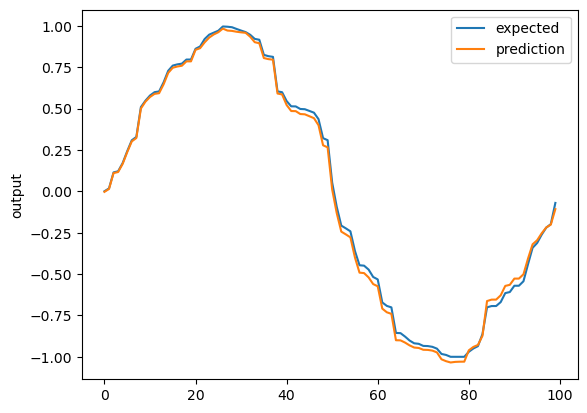

In [3]:
import torch
import torch.nn as nn
import numpy as np

# Data Preparation
rng = np.random.RandomState(1)
x = torch.tensor(np.sort(360 * rng.rand(100, 1), axis=0)).float()
y = torch.tensor(np.sin(x * (np.pi / 180.0)).ravel()).view(-1, 1).float()


# Model
model = nn.Sequential(
    nn.Linear(x.shape[1], 100),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Linear(50, 25),
    nn.ReLU(),
    nn.Linear(25, 1)
)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(25000):
    optimizer.zero_grad()
    outputs = model(x)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()

# Predictions
pred = model(x).detach().numpy()

print("Actual")
print(y[:5].numpy())

print("Pred")
print(pred[:5])

# Use the same chart_regression function
chart_regression(pred.flatten(), y.numpy(), sort=False)

As you can see, the neural network creates a reasonably close approximation of the random sine function.

## Multi-Output Regression

Unlike most models, neural networks can provide multiple regression outputs.  This feature allows a neural network to generate various outputs for the same input.  For example, you might train the MPG data set to predict MPG and horsepower.  One area in that multiple regression outputs can be helpful is autoencoders.  The following diagram shows a multi-regression neural network.  As you can see, there are multiple output neurons.  Usually, you will use multiple output neurons for classification.  Each output neuron will represent the probability of one of the classes.  However, in this case, it is a regression neural network.  Figure 13.MRG shows multi-output regression.

**Figure 14.MRG: Multi-Output Regression**
![Multi-Output Regression](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_13_multi_output.png "Multi-Output Regression")

The following program uses a multi-output regression to predict both [sin](https://en.wikipedia.org/wiki/Trigonometric_functions#Sine.2C_cosine_and_tangent) and [cos](https://en.wikipedia.org/wiki/Trigonometric_functions#Sine.2C_cosine_and_tangent) from the same input data.

In [4]:
# Data Preparation
rng = np.random.RandomState(1)
x = torch.tensor(np.sort(360 * rng.rand(100, 1), axis=0)).float()
y = torch.tensor(np.array([np.pi * np.sin(x * (np.pi / 180.0)).ravel(), 
                           np.pi * np.cos(x * (np.pi / 180.0)).ravel()]).T).float()

# Model
model = nn.Sequential(
    nn.Linear(x.shape[1], 100),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Linear(50, 25),
    nn.ReLU(),
    nn.Linear(25, 2)  # Two output neurons
)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(25000):
    optimizer.zero_grad()
    outputs = model(x)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()

# Predictions
pred = model(x).detach().numpy()

# Evaluation
score = np.sqrt(((pred - y.numpy()) ** 2).mean())
print("Score (RMSE): {}".format(score))

print("Predicted:")
print(pred[20:25])

print("Expected:")
print(y[20:25].numpy())


Score (RMSE): 0.09222161769866943
Predicted:
[[2.6851084  1.5557812 ]
 [2.733617   1.4784318 ]
 [2.886411   1.193748  ]
 [2.9791882  0.98964155]
 [3.0051618  0.8673663 ]]
Expected:
[[2.707653   1.593179  ]
 [2.7513845  1.5164063 ]
 [2.8930001  1.2248085 ]
 [2.9760394  1.0063769 ]
 [3.0138173  0.88685423]]


## Simple Autoencoder

An autoencoder is a neural network with the same number of input neurons as it does outputs. The hidden layers of the neural network will have fewer neurons than the input/output neurons. Because there are fewer neurons, the auto-encoder must learn to encode the input to the fewer hidden neurons. The predictors (x) and output (y) are precisely the same in an autoencoder. Because of this, we consider autoencoders to be unsupervised. Figure 14.AUTO shows an autoencoder. 

**Figure 14.AUTO: Simple Auto Encoder**
![Simple Auto Encoder](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_13_auto_encode.png "Simple Auto Encoder")

The following program demonstrates a very simple autoencoder that learns to encode a sequence of numbers. Fewer hidden neurons will make it more difficult for the autoencoder to understand.

In [5]:
# Data Preparation
x = torch.tensor([range(10)]).float()

# Model
model = nn.Sequential(
    nn.Linear(x.shape[1], 3),
    nn.ReLU(),
    nn.Linear(3, x.shape[1])  # Multiple output neurons
)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(1000):
    optimizer.zero_grad()
    outputs = model(x)
    loss = criterion(outputs, x)
    loss.backward()
    optimizer.step()

# Predictions
pred = model(x).detach().numpy()

# Evaluation
score = np.sqrt(((pred - x.numpy()) ** 2).mean())
print("Score (RMSE): {}".format(score))
print(pred)


Score (RMSE): 0.0003088458615820855
[[-1.8060207e-05  1.0000151e+00  2.0000055e+00  2.9999840e+00
   4.0000010e+00  5.0000296e+00  5.9999228e+00  7.0000453e+00
   8.0001478e+00  8.9990396e+00]]


## Autoencode (single image)

We are now ready to build a simple image autoencoder.  The program below learns a capable encoding for the image.  You can see the distortions that occur.

torch.Size([49152])
tensor([0.7961, 0.8510, 0.9412,  ..., 0.3686, 0.3608, 0.2667])


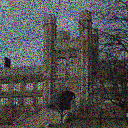

In [6]:
%matplotlib inline
from PIL import Image
import numpy as np
import requests
from io import BytesIO
import torch
import torch.nn as nn
import torch.optim as optim

url = "https://data.heatonresearch.com/images/jupyter/brookings.jpeg"
response = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})
img = Image.open(BytesIO(response.content))
img = img.resize((128, 128), Image.LANCZOS)
img_array = np.asarray(img).flatten() / 255.0
img_tensor = torch.tensor(img_array, dtype=torch.float32)

print(img_tensor.shape)
print(img_tensor)

model = nn.Sequential(
    nn.Linear(img_tensor.shape[0], 10),
    #nn.ReLU(),
    nn.Linear(10, img_tensor.shape[0])
)

loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters())
img_tensor = img_tensor.unsqueeze(0)  # Add a batch dimension

for epoch in range(1000):
    optimizer.zero_grad()
    output = model(img_tensor)
    loss = loss_function(output, img_tensor)
    loss.backward()
    optimizer.step()

rows, cols = img.size
output = output.squeeze(0) * 255  # Scale back to original range
img_array2 = output.detach().numpy().reshape(rows, cols, 3)
img_array2 = np.clip(img_array2, 0, 255)  # Clip to ensure values are within 0-255
img_array2 = img_array2.astype(np.uint8)  # Convert to uint8 for image representation
img2 = Image.fromarray(img_array2, 'RGB')

# Display the image
img2


## Standardize Images

When processing several images together, it is sometimes essential to standardize them.  The following code reads a sequence of images and causes them to all be of the same size and perfectly square.  If the input images are not square, cropping will occur.

/var/folders/ys/hps4l__90n3_2gns3lzbt9fw0000gn/T/ipykernel_2505/1938739860.py:34: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((128, 128), Image.ANTIALIAS)


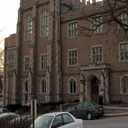

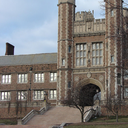

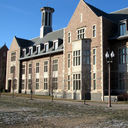

In [7]:
from PIL import Image, ImageFile
import requests
from io import BytesIO
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt

# Load and process the images
images = [
    "https://data.heatonresearch.com/images/jupyter/Brown_Hall.jpeg",
    "https://data.heatonresearch.com/images/jupyter/brookings.jpeg",
    "https://data.heatonresearch.com/images/jupyter/WUSTLKnight.jpeg"
]

def make_square(img):
    cols, rows = img.size
    
    if rows > cols:
        pad = (rows - cols) / 2
        img = img.crop((pad, 0, cols, cols))
    else:
        pad = (cols - rows) / 2
        img = img.crop((0, pad, rows, rows))
    
    return img

x = []

for url in images:
    ImageFile.LOAD_TRUNCATED_IMAGES = False
    response = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})
    img = Image.open(BytesIO(response.content))
    img = make_square(img)
    img = img.resize((128, 128), Image.ANTIALIAS)
    display(img)
    img_array = np.array(img, dtype=np.float32) / 255.0  # Normalize to [0, 1]
    img_array = img_array.flatten()
    x.append(img_array)

x = np.array(x)
x = torch.tensor(x, dtype=torch.float32).to(device)  # Move data to the device

## Image Autoencoder (multi-image)

Autoencoders can learn the same encoding for multiple images.  The following code learns a single encoding for numerous images. 

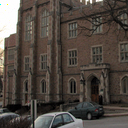

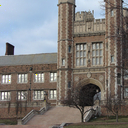

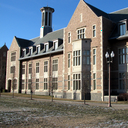

In [8]:
# Define the neural network using Sequential
model = nn.Sequential(
    nn.Linear(x.shape[1], 500),
    nn.ReLU(),
    nn.Linear(500, x.shape[1])
).to(device)  # Move model to the device

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# Train the model
for epoch in range(7500):
    # Forward pass
    outputs = model(x)
    loss = criterion(outputs, x)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Test the model
with torch.no_grad():
    pred = model(x)
    pred = pred.cpu().numpy()  # Move predictions back to CPU for processing

# Display the generated images
cols, rows = img.size
for i in range(len(pred)):
    img_array2 = pred[i].reshape(rows, cols, 3)
    img_array2 = img_array2 * 255  # Convert back to [0, 255]
    img_array2 = img_array2.astype(np.uint8)
    img2 = Image.fromarray(img_array2, 'RGB')
    display(img2)


## Adding Noise to an Image

Autoencoders can handle noise.  First, it is essential to see how to add noise to an image.  There are many ways to add such noise.  The following code adds random black squares to the image to produce noise.

Rows: 128, Cols: 128
(128, 128, 3)


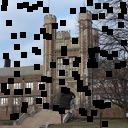

In [9]:
%matplotlib inline
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests
from io import BytesIO

# Seed the random number generator, so images are consistant
np.random.seed(42)  

def add_noise(a):
    a2 = a.copy()
    rows = a2.shape[0]
    cols = a2.shape[1]
    s = int(min(rows,cols)/20) # size of spot is 1/20 of smallest dimension
    
    for i in range(100):
        x = np.random.randint(cols-s)
        y = np.random.randint(rows-s)
        a2[y:(y+s),x:(x+s)] = 0
        
    return a2

url = "https://data.heatonresearch.com/images/jupyter/brookings.jpeg"

response = requests.get(url,headers={'User-Agent': 'Mozilla/5.0'})
img = Image.open(BytesIO(response.content))
img.load()
img = img.resize((128, 128), Image.LANCZOS)

img_array = np.asarray(img)
rows = img_array.shape[0]
cols = img_array.shape[1]

print("Rows: {}, Cols: {}".format(rows,cols))

# Create new image
img2_array = img_array.astype(np.uint8)
print(img2_array.shape)
img2_array = add_noise(img2_array)
img2 = Image.fromarray(img2_array, 'RGB')
img2        

## Denoising Autoencoder

You design a denoising autoencoder to remove noise from input signals. You train the network to convert noisy data ($x$) to the original input ($y$). The $y$ becomes each image/signal (just like a normal autoencoder); however, the $x$ becomes a version of $y$ with noise added.  Noise is artificially added to the images to produce $x$.  The following code creates ten noisy versions of each of the images.

In [10]:
# HIDE OUTPUT 3
%matplotlib inline
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests
import numpy as np
from io import BytesIO
from IPython.display import display, HTML

images = [
    "https://data.heatonresearch.com/images/jupyter/Brown_Hall.jpeg",
    "https://data.heatonresearch.com/images/jupyter/brookings.jpeg",
    "https://data.heatonresearch.com/images/jupyter/WUSTLKnight.jpeg"
]

def make_square(img):
    cols,rows = img.size
    
    if rows>cols:
        pad = (rows-cols)/2
        img = img.crop((pad,0,cols,cols))
    else:
        pad = (cols-rows)/2
        img = img.crop((0,pad,rows,rows))
    
    return img
    
x = []    
y = []
loaded_images = []
    
for url in images:
    ImageFile.LOAD_TRUNCATED_IMAGES = False
    response = requests.get(url,headers={'User-Agent': 'Mozilla/5.0'})
    img = Image.open(BytesIO(response.content))
    img.load()
    img = make_square(img)
    img = img.resize((128,128), Image.LANCZOS)
    
    loaded_images.append(img)

    for i in range(10):
        img_array = np.asarray(img)
        img_array_noise = add_noise(img_array)
        
        img_array = img_array.flatten()
        img_array = img_array.astype(np.float32)
        img_array = (img_array-128)/128
        
        img_array_noise = img_array_noise.flatten()
        img_array_noise = img_array_noise.astype(np.float32)
        img_array_noise = (img_array_noise-128)/128
        
        x.append(img_array_noise)
        y.append(img_array)
    
x = np.array(x)
x = torch.tensor(x, dtype=torch.float32).to(device)  

y = np.array(y)
y = torch.tensor(y, dtype=torch.float32).to(device)  

print("Training size:")
print(x.shape)
print(y.shape)

Training size:
torch.Size([30, 49152])
torch.Size([30, 49152])


We now train the autoencoder neural network to transform the noisy images into clean images.

In [11]:
# Define the neural network using Sequential
model = nn.Sequential(
    nn.Linear(x.shape[1], 500),
    nn.ReLU(),
    nn.Linear(500, x.shape[1])
).to(device)  # Move model to the device

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# Train the model
for epoch in range(10000):
    # Forward pass
    outputs = model(x)
    loss = criterion(outputs, x)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


We are now ready to evaluate the results.

*** Trial 1
With noise:


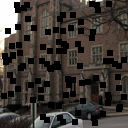

After auto encode noise removal


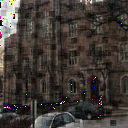

*** Trial 2
With noise:


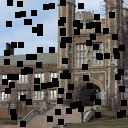

After auto encode noise removal


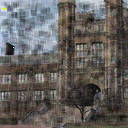

*** Trial 3
With noise:


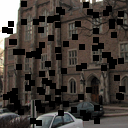

After auto encode noise removal


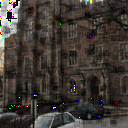

In [12]:
for z in range(3):
    print("*** Trial {}".format(z+1))
    
    # Choose random image
    i = np.random.randint(len(loaded_images))
    img = loaded_images[i]
    img_array = np.asarray(img)
    cols, rows = img.size

    # Add noise
    img_array_noise = add_noise(img_array)    

    #Display noisy image
    img2 = img_array_noise.astype(np.uint8)
    img2 = Image.fromarray(img2, 'RGB')
    print("With noise:")
    display(img2)

    # Present noisy image to auto encoder
    img_array_noise = img_array_noise.flatten()
    img_array_noise = img_array_noise.astype(np.float32)
    img_array_noise = (img_array_noise-128)/128
    img_array_noise = np.array([img_array_noise])
    x = torch.tensor(img_array_noise, dtype=torch.float32).to(device)

    # Test the model
    with torch.no_grad():
        pred = model(x)
        pred = pred.cpu().numpy()  # Move predictions back to CPU for processing

    # Display neural result
    img_array2 = pred.reshape(rows,cols,3)
    img_array2 = (img_array2*128)+128
    img_array2 = img_array2.astype(np.uint8)
    img2 = Image.fromarray(img_array2, 'RGB')
    print("After auto encode noise removal")
    display(img2)